In [1]:
from qiskit import *
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.nn import MaxPool2d
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, normalize
from qiskit.circuit import ParameterVector, Parameter
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit import execute
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from sklearn.decomposition import PCA

In [7]:
qc = QuantumCircuit(4)
encoder = qc.to_gate()
encoder.name = 'Encoder'

qc = QuantumCircuit(4)
ansatz = qc.to_gate()
ansatz.name = 'Ansatz'

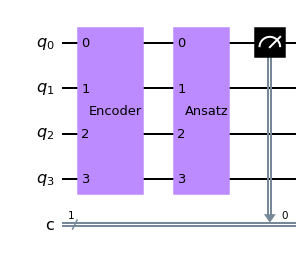

In [9]:
qc = QuantumCircuit(4,1)
qc.append(encoder, range(4))
qc.append(ansatz, range(4))
qc.measure(0,0)
qc.draw('mpl')

In [134]:
# Concentrating on the first 100 samples
n_samples = 50

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

x_train = np.array([X_train[i][0].numpy() for i in idx])
y_train = np.array([X_train[i][1] for i in idx])

x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [135]:
n_samples = 30

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

x_test = np.array([X_test[i][0].numpy() for i in idx])
y_test = np.array([X_test[i][1] for i in idx])

x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [136]:
print(x_train.shape)
print(x_test.shape)

h = x_train.shape[2]
w = x_train.shape[3]

x_train = x_train.reshape(-1,h,w)
x_test = x_test.reshape(-1,h,w)

print(x_train.shape)
print(x_test.shape)

(100, 1, 28, 28)
(60, 1, 28, 28)
(100, 28, 28)
(60, 28, 28)


In [137]:
def display_images(x, y):
    n_samples_show = 10
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    while n_samples_show > 0:
        index = np.random.randint(0, x.shape[0])
        image, target = x[index], y[index]

        axes[n_samples_show - 1].imshow(image, cmap='gray')
        axes[n_samples_show - 1].set_xticks([])
        axes[n_samples_show - 1].set_yticks([])
        axes[n_samples_show - 1].set_title(format(target))

        n_samples_show -= 1

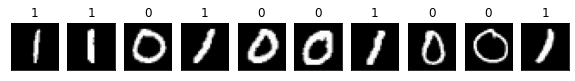

In [138]:
display_images(x_train, y_train)

In [139]:
x_train = x_train.reshape(-1,h*w)
x_test = x_test.reshape(-1,h*w)


print(x_train.shape)
print(x_test.shape)

(100, 784)
(60, 784)


In [140]:
n_components = 36
pca = PCA(n_components)
pca.fit(x_train)
print("Cumulative sum for train:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_train = pca.transform(x_train)

pca.fit(x_test)
print("Cumulative sum for test:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_test = pca.transform(x_test)

Cumulative sum for train: 93.94023
Cumulative sum for test: 97.38891


In [141]:
print(x_train.shape)
print(x_test.shape)

(100, 36)
(60, 36)


In [142]:
x_train = normalize(x_train)
x_test = normalize(x_test)

In [143]:
# threshold = 0

# x_train = np.array(x_train > threshold, dtype=np.float32)
# x_test = np.array(x_test > threshold, dtype=np.float32)

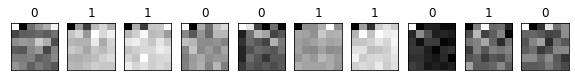

In [144]:
display_images(x_train.reshape(-1,6,6),y_train)

In [145]:
print(x_train.shape)
print(x_test.shape)
print(x_train.max(),x_train.min())

(100, 36)
(60, 36)
0.81959575 -0.8583514


In [146]:
def cirq_layer(qc, readout, data_qubits, gate_name):
    theta_list = ParameterVector('θ' + gate_name, length=len(data_qubits))
    if gate_name == 'xx':
        for i in data_qubits:
            qc.rxx(theta_list[i-1], i, readout)
    elif gate_name == 'zz':
        for i in data_qubits:
            qc.rzz(theta_list[i-1], i, readout)
    else:
        raise ValueError("gate name must be either xx or zz")
    return qc

In [147]:
n = n_components + 1
backend = AerSimulator()

# Data encoding circuit
in_thetas = ParameterVector('θ_in', length=n)
feature_map  = QuantumCircuit(n,1)
for i in range(1,n):
    feature_map.rx(in_thetas[i], i)

# variational circuit
var_form = QuantumCircuit(n,1)
var_form.x(0)
var_form.h(0)
var_form = cirq_layer(var_form, 0, range(1,n), 'xx')
var_form = cirq_layer(var_form, 0, range(1,n), 'zz')
var_form.h(0)

circuit = feature_map.compose(var_form)
circuit.measure(0,0)

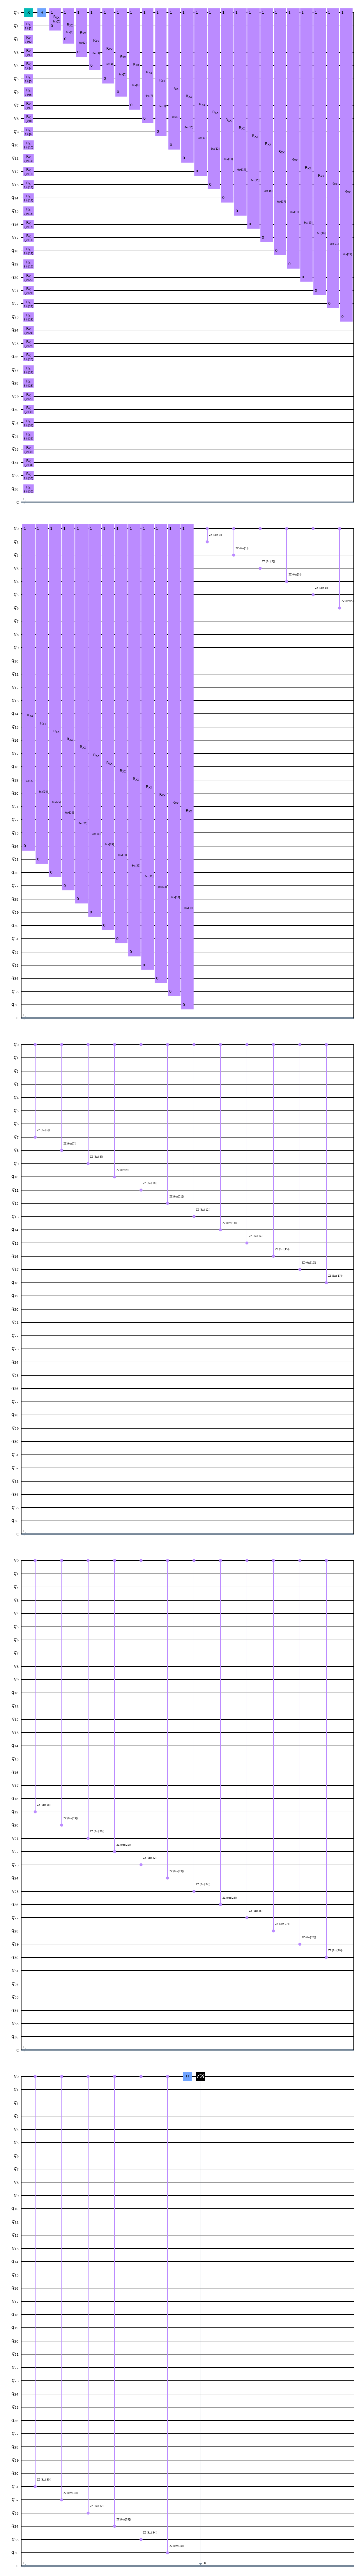

In [148]:
circuit.draw('mpl')

In [149]:
var_form.num_parameters

72

In [150]:
def circuit_parameters(x, variational):
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.parameters):
        parameters[p] = variational[i]
    return parameters

In [152]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 0
    else:
        return 1

In [153]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [154]:
def classification_probability(data, variational):
    qc_list = [circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    results =  execute(qc_list, backend).result()
    classification = [label_probability(results.get_counts(c)) for c in qc_list]
    return classification

In [155]:
costs = []
accuracies = []

In [156]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))

def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0
    predictions = []
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
        if classification[0] > classification[1]:
            predictions.append(0)
        else:
            predictions.append(1)
    cost /= len(data)
    costs.append(cost)
    acc = sum(predictions == labels)/len(labels)
    accuracies.append(acc)
    print('cost:', np.around(cost,4), 'acc: ',np.around(acc, 4))
    return cost

In [157]:
optimizer = SPSA(maxiter=100, learning_rate = 0.001, perturbation=0.001)

initial_point = np.random.random(circuit.num_parameters)

objective_function = lambda variational: cost_function(x_train,
                                                       y_train,
                                                       variational)

In [158]:
# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

cost: 0.7718 acc:  0.5
cost: 0.7763 acc:  0.52
cost: 0.7774 acc:  0.54
cost: 0.7747 acc:  0.5
cost: 0.7739 acc:  0.48
cost: 0.7722 acc:  0.53
cost: 0.7717 acc:  0.53
cost: 0.7684 acc:  0.52
cost: 0.7714 acc:  0.54
cost: 0.7725 acc:  0.53
cost: 0.7724 acc:  0.51
cost: 0.7682 acc:  0.51
cost: 0.7689 acc:  0.5
cost: 0.7688 acc:  0.51
cost: 0.7717 acc:  0.51
cost: 0.7704 acc:  0.54
cost: 0.7638 acc:  0.49
cost: 0.7657 acc:  0.53
cost: 0.7698 acc:  0.55
cost: 0.7728 acc:  0.54
cost: 0.7724 acc:  0.52
cost: 0.7685 acc:  0.51
cost: 0.77 acc:  0.55
cost: 0.7642 acc:  0.5
cost: 0.7688 acc:  0.49
cost: 0.7663 acc:  0.53
cost: 0.7657 acc:  0.5
cost: 0.7706 acc:  0.51
cost: 0.7719 acc:  0.5
cost: 0.7692 acc:  0.52
cost: 0.7704 acc:  0.52
cost: 0.768 acc:  0.52
cost: 0.7649 acc:  0.51
cost: 0.7642 acc:  0.51
cost: 0.7696 acc:  0.5
cost: 0.7657 acc:  0.51
cost: 0.7674 acc:  0.52
cost: 0.7734 acc:  0.49
cost: 0.7705 acc:  0.5
cost: 0.7712 acc:  0.53
cost: 0.7697 acc:  0.5
cost: 0.7726 acc:  0.51
cost

KeyboardInterrupt: 

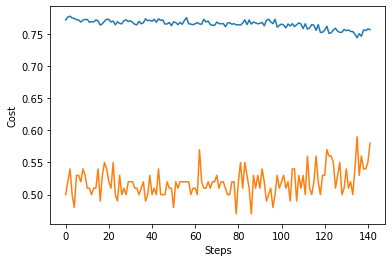

In [159]:
fig = plt.figure()
plt.plot(costs)
plt.plot(accuracies)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [160]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

accuracy, prediction = score_classifier(x_test, y_test, opt_var)
accuracy

NameError: name 'opt_var' is not defined